# Activity indicator modelling

In [1]:
import pprint
import copy
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
from george.gp import LinAlgError
import yaml
from matplotlib import cm
import rv_analysis_tools as rv
import importlib
importlib.reload(rv)
from astropy.timeseries import LombScargle
import dynesty
from dynesty import plotting as dyplot
import radvel
import pandas as pd
import pickle

## Target selection

In [2]:
print('Welcome to the joint RV analysis tool!')
print('Which star would you like to analyze?')

star = input('Enter star name:')

print('Loading input file and data...')

# Read input file
try: 
    with open(f'stars/{star}/input.yaml', 'r') as file:
        yaml_file = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

Welcome to the joint RV analysis tool!
Which star would you like to analyze?
Loading input file and data...


## Loading data

In [3]:
data = rv.DataLoader(yaml_file)
working_path = f"stars/{star}/CRAPanalysis/activity/"

i_shared = data.activity_priors['shared_params']
gp_labels = rv.generate_param_names(['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot'],
                                    i_shared, data.instruments)
print('Done.')

Done.


Matplotlib preferences

In [4]:
# Styling parameters
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'legend.fontsize': 'small',
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'figure.autolayout': True,
})

colors = plt.cm.jet(np.linspace(1, 0, len(data.instruments)))

Quick look at the activity indicators

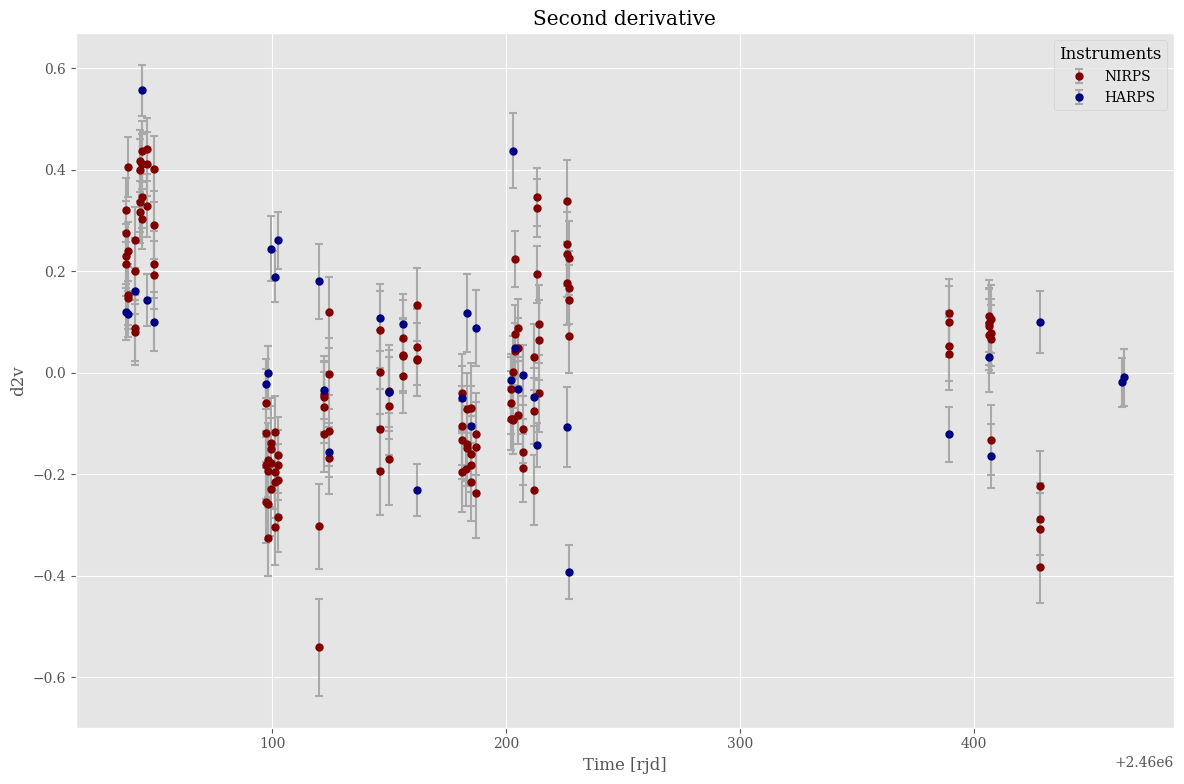

In [5]:
# Plot the chosen activity indicator
nfigs = 2 - data.no_Dtemp
fig, axes = plt.subplots(nfigs, 1, figsize=(12, 8), sharex=True)

for idx, instrument in enumerate(data.instruments):
    if not data.no_Dtemp:
        axes[0].errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
        axes[1].errorbar(data.t_rv[instrument], data.Dtemp[instrument], yerr=data.sDtemp[instrument], fmt='o',
                        label=instrument, color=colors[idx], 
                    ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)

        axes[1].set_xlabel('Time [rjd]')
        axes[0].set_ylabel('d2v')
        axes[0].legend(title='Instruments')
        axes[0].set_title('Second derivative')

        axes[1].set_title('Differential temperature')
        axes[1].legend(title='Instruments')
        axes[1].set_ylabel('Dtemp')
    else: 
        axes.errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
        axes.set_xlabel('Time [rjd]')
        axes.set_ylabel('d2v')
        axes.legend(title='Instruments')
        axes.set_title('Second derivative')
plt.show()

Choosing the activity indicator

In [6]:
if data.activity_priors['chosen_activity'] == 'd2v': 
    act, sact = data.d2v, data.sd2v

if data.activity_priors['chosen_activity'] == 'Dtemp': 
    act, sact = data.Dtemp, data.sDtemp
    
print(f'You chose to use the {data.activity_priors["chosen_activity"]} activity indicator.')

You chose to use the d2v activity indicator.


Periodogram of the chosen activity indicator

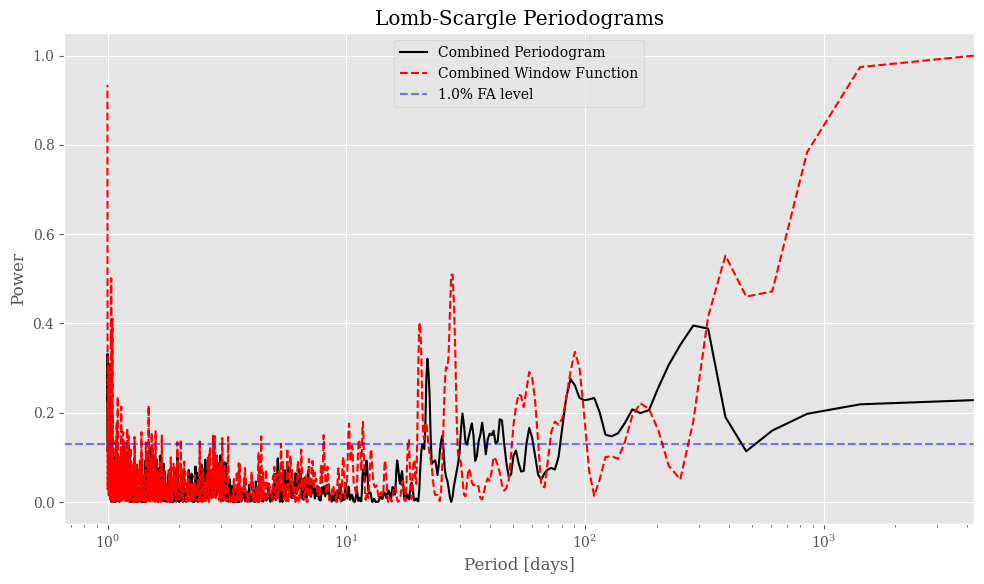

<Figure size 640x480 with 0 Axes>

In [7]:
rv.plot_lombscargle_periodograms(data.t_rv, act, sact, combined = True)
plt.savefig(working_path + 'lombscargle_periodograms.png')

## Creating the GP object

GP params order: 

0. `mu` (offset)
1. `log_wn` (jitter noise)
2. `log_amp` (amplitude)
3. `log_lambda` (Coherence length)
4. `gamma` (Number of sub-structures)
5. `log_Prot` (Rotation period)

First guess

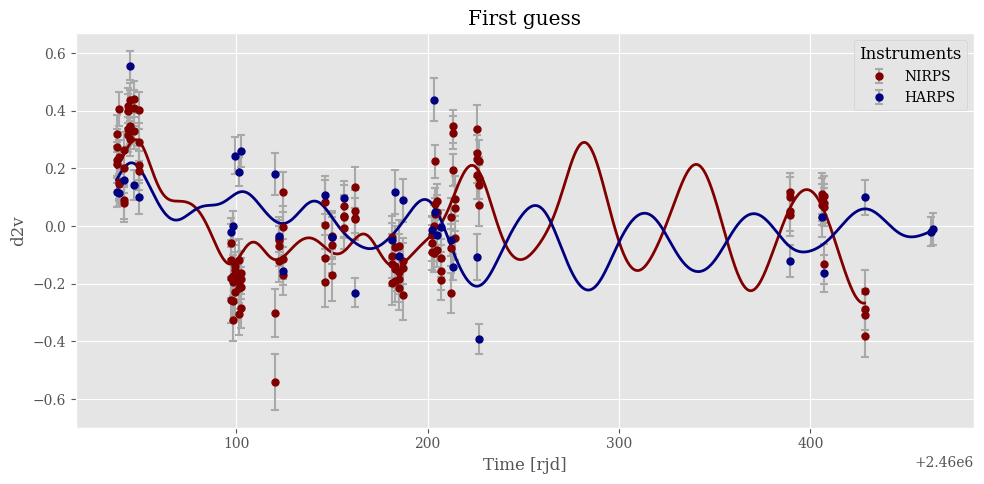

In [8]:
act_gp = {} # Dictionary to store the GP for each instrument
p0 = {} # Dictionary to store the initial guess for the hyperparameters

for instrument in data.instruments: 
    
    p0[instrument] = rv.juliet_to_george([np.mean(act[instrument]), 0.1, np.std(act[instrument]),
           data.activity_priors['GP_length']['guess'], data.activity_priors['GP_gamma']['guess'], data.activity_priors['GP_Prot']['guess']]) # Initial guess for the hyperparameters
    
    act_gp[instrument] = rv.QP_GP_Model(p0[instrument], data.t_rv[instrument], act[instrument], sact[instrument])
# Plot the first guess
# Plot the chosen activity indicator
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
                    
for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], act[instrument], yerr=sact[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], act_gp[instrument].predict(act[instrument], data.t_mod[instrument]), color=colors[idx], lw=2)

ax.set_xlabel('Time [rjd]')
ax.set_ylabel(data.activity_priors['chosen_activity'])
ax.legend(title='Instruments')
ax.set_title('First guess')
plt.show()

Combining the shared parameters and computing initial guess

In [9]:
p0_separated = []

for instrument in data.instruments: 
    p0_separated += list(p0[instrument])

p0_vect = rv.params_vector(p0_separated, data.instruments, i_shared, num_planets = data.nplanets, gp_only=True)

comb_p0 = p0_vect.combine()

Save the priors to a file

In [10]:
# Write the priors to a file 
with open(working_path + 'activity_priors.yaml', 'w') as file:
    yaml.dump(data.activity_priors, file)

## Running `emcee`

In [11]:
# MCMC fit of the GP hyperparameters 
nwalkers, ndim = 32, len(comb_p0)
num_warmup = 50*ndim
num_post_samples = 500*ndim
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    rv.emcee_act_log_post,
    args=(act_gp, act, data, i_shared),
    # moves=[emcee.moves.StretchMove()]
    moves=[emcee.moves.DEMove()],
)
# Change the dimension of p0 with the number of walkers
comb_p0_emcee = np.array([comb_p0 + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)])

$\color{red}{\textrm{RUNNING CELL}}$

In [12]:
if data.run_activity == True:
    print('Running MCMC fit for the activity indicator...')
    sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True, store=True)
    act_post_samples = sampler.get_chain(discard=num_warmup)
    np.save(working_path + 'act_post_samples.npy', act_post_samples)
    
    act_log_post_probs = sampler.get_log_prob(discard=num_warmup)
    np.save(working_path + 'act_log_post_probs.npy', act_log_post_probs)
    print('Done')

else: 
    print('Loading previous MCMC fit for the activity indicator...')

Running MCMC fit for the activity indicator...


  0%|          | 2/1350 [00:00<01:13, 18.39it/s]

100%|██████████| 1350/1350 [00:54<00:00, 24.57it/s]

Done


Load the already ran target

In [13]:
act_post_samples = np.load(working_path + 'act_post_samples.npy', allow_pickle=True)

Traceplot

Plotting traceplot...
Done.


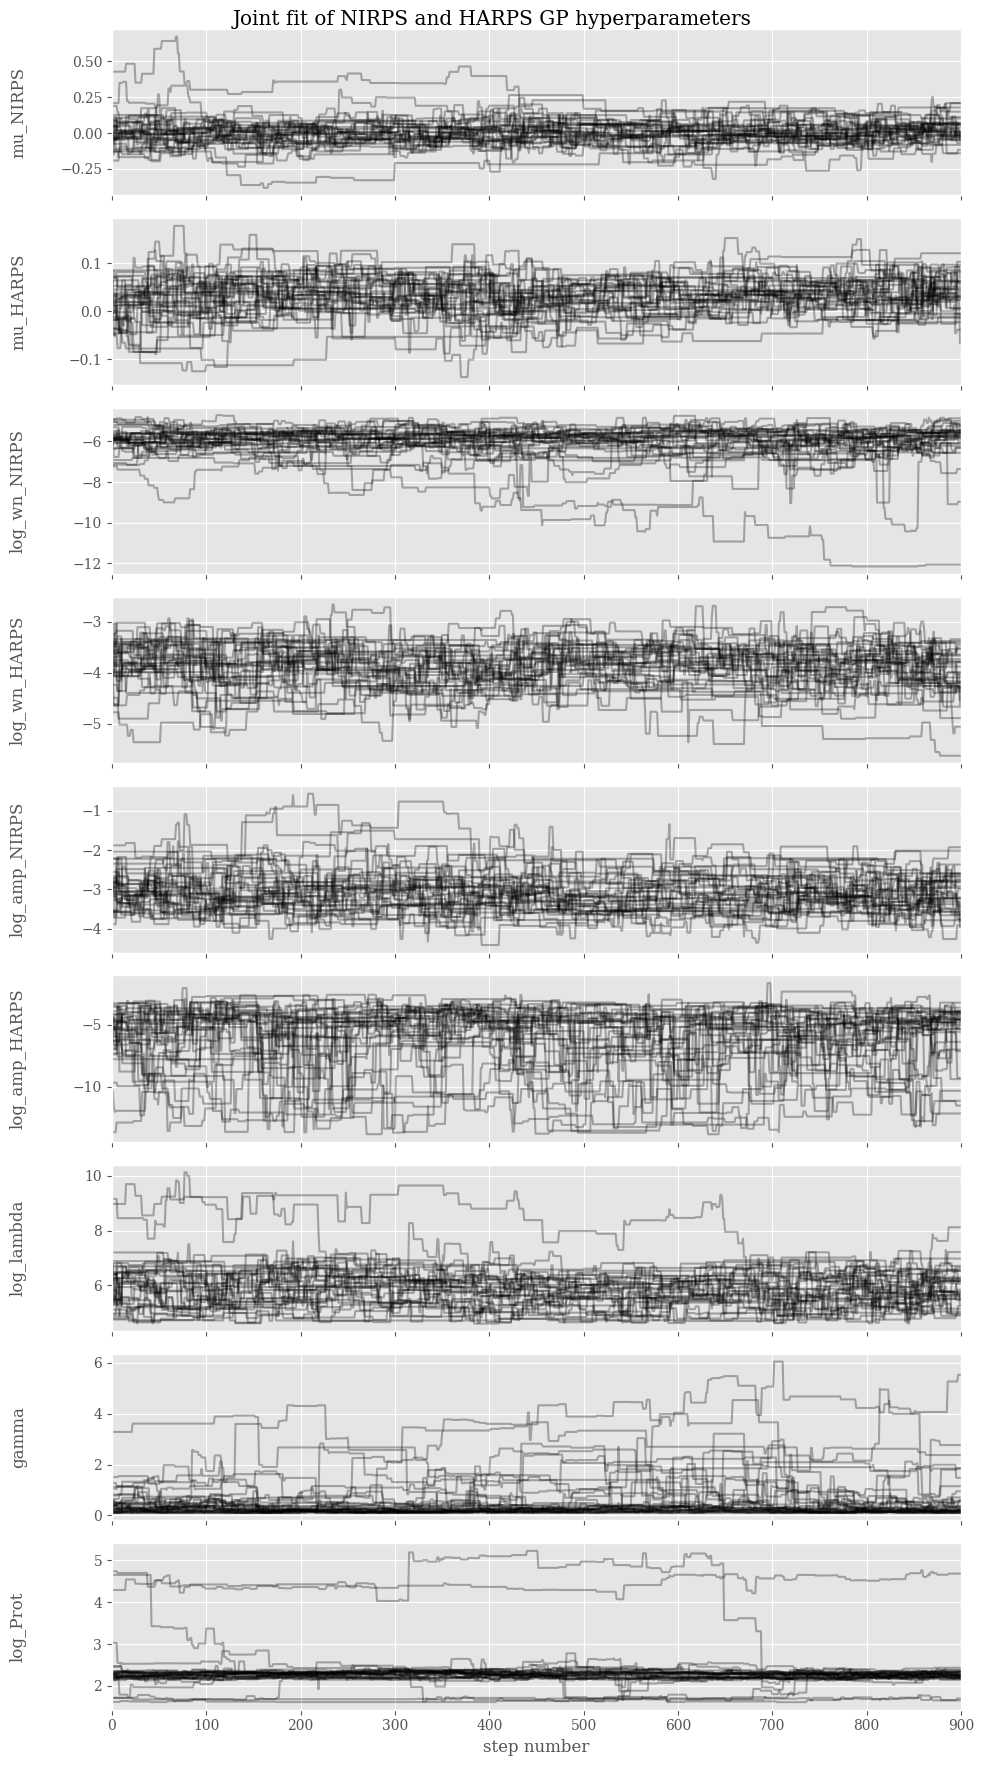

In [14]:
print('Plotting traceplot...')
fig, axes = plt.subplots(ndim, figsize=(10, ndim*2), sharex=True)


for i in range(ndim):
    ax = axes[i]
    ax.plot(act_post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(act_post_samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(gp_labels[i])
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS GP hyperparameters')
plt.savefig(working_path + 'act_GP_traceplot.png')
print('Done.')

Cornerplot

Creating corner plot for the activity indicator
Done.


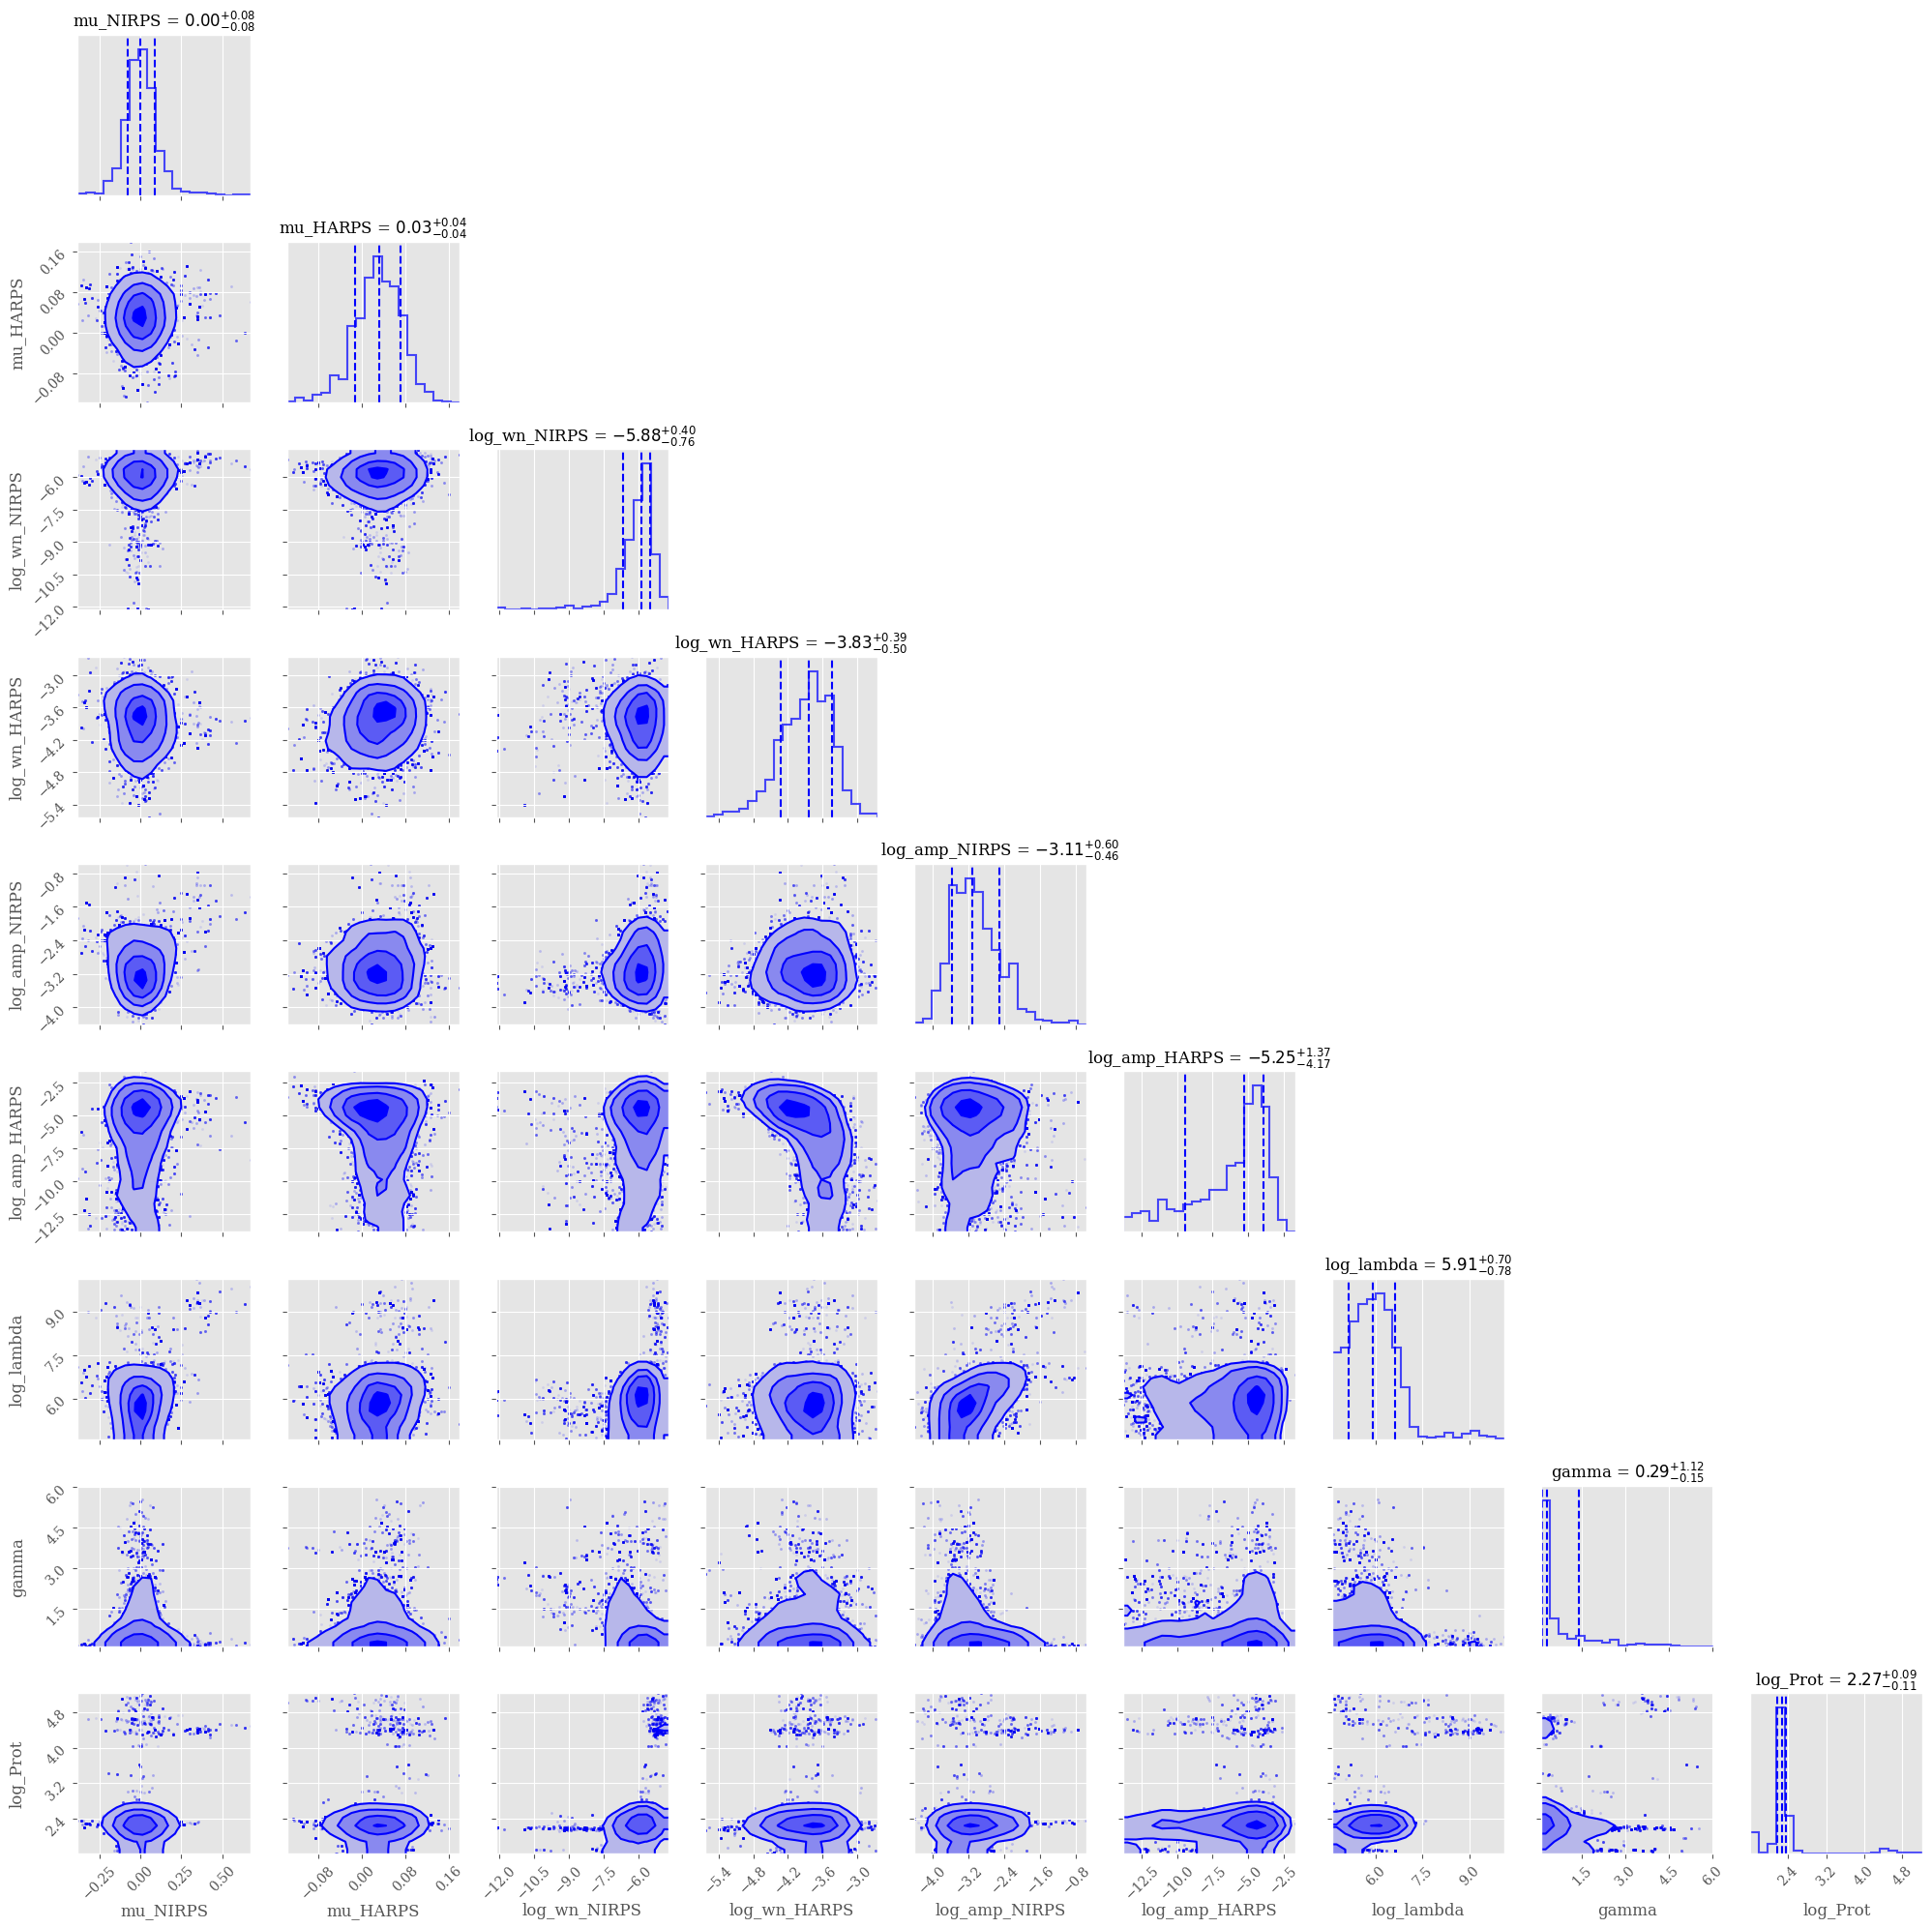

In [15]:
print('Creating corner plot for the activity indicator')
#truths = [None, None, None, None, None, None, None, None, np.log(data.data['star']['period'])]

corner.corner(act_post_samples.reshape(-1, ndim), quantiles=[0.16, 0.5, 0.84],
              show_titles=True,
              title_kwargs={"fontsize": 12},
              color="blue",  # Set a color scheme (optional)
              hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
              fill_contours=True,  # Show contours for data density
              fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
              smooth=True,  # Improve smoothness of contours
              fontsize=10,  # Set font size for labels and tick marks
              #truths=truths,
              #truth_color = 'orange',
              labels=gp_labels
)
plt.tight_layout()
plt.savefig(working_path + 'act_GP_cornerplot.png')
print('Done.')

Best parameters

In [16]:
# Get the best parameters
med_params = np.median(act_post_samples.flatten().reshape(-1, ndim), axis=0)
separated_med_params, separated_med_params_dict = rv.separate_gp_params(med_params, i_shared, data.instruments)
max_params = rv.get_max_likelihood_params(act_post_samples.flatten().reshape(-1, ndim), act_log_post_probs.flatten())
separated_max_params_dict = rv.separate_gp_params(max_params, i_shared, data.instruments)

# Get the uncertainty
errors = np.percentile(act_post_samples.flatten().reshape(-1, ndim), [16, 84], axis=0)

print('Median likelihood parameters')
print('--------------------------')
# Show the median likelihood parameters
with open(working_path + 'median_likelihood_params.txt', "w") as text_file:
    for i, label in enumerate(gp_labels):
        print(f'{label}: {med_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}')
        text_file.write(f'{label}: {med_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}\n')
    
print('Maximum likelihood parameters')
print('--------------------------')
# Show the maximum likelihood parameters
with open(working_path + 'maximum_likelihood_params.txt', "w") as text_file:
    for i, label in enumerate(gp_labels):
        print(f'{label}: {max_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}')
        text_file.write(f'{label}: {max_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}\n')

Median likelihood parameters
--------------------------
mu_NIRPS: 0.001 - -0.078 + 0.086
mu_HARPS: 0.031 - -0.012 + 0.071
log_wn_NIRPS: -5.883 - -6.643 + -5.482
log_wn_HARPS: -3.834 - -4.331 + -3.444
log_amp_NIRPS: -3.111 - -3.566 + -2.510
log_amp_HARPS: -5.254 - -9.424 + -3.886
log_lambda: 5.909 - 5.134 + 6.611
gamma: 0.285 - 0.138 + 1.407
log_Prot: 2.274 - 2.166 + 2.362
Maximum likelihood parameters
--------------------------
mu_NIRPS: 0.002 - -0.078 + 0.086
mu_HARPS: 0.049 - -0.012 + 0.071
log_wn_NIRPS: -5.918 - -6.643 + -5.482
log_wn_HARPS: -4.011 - -4.331 + -3.444
log_amp_NIRPS: -2.974 - -3.566 + -2.510
log_amp_HARPS: -4.643 - -9.424 + -3.886
log_lambda: 5.841 - 5.134 + 6.611
gamma: 0.185 - 0.138 + 1.407
log_Prot: 2.285 - 2.166 + 2.362


Choose maximum or median parameters as best parameters

In [17]:
best_params = med_params
separated_best_params = separated_med_params
separated_best_params_dict = separated_med_params_dict

#best_params = max_params
#separated_best_params = separated_max_params
#separated_best_params_dict = separated_max_params_dict

Creating posterior samples

In [18]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 20
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in act_gp.keys()}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)

    # Separate the parameters for each instrument
    _, act_post_samples_dict = rv.separate_gp_params(act_post_samples[n, w], i_shared, act_gp.keys())

    try:
        for instrument, gp_model in act_gp.items():
            gp_params = act_post_samples_dict[instrument]
            gp_model.gp.set_parameter_vector(gp_params)
            model_post_samples[instrument].append(gp_model.gp.sample_conditional(act[instrument], data.t_mod[instrument]))
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in act_gp.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

print('Done.')

Creating posterior samples...
Done.


Visualize the best fit

Plotting the best-fit results


Done.


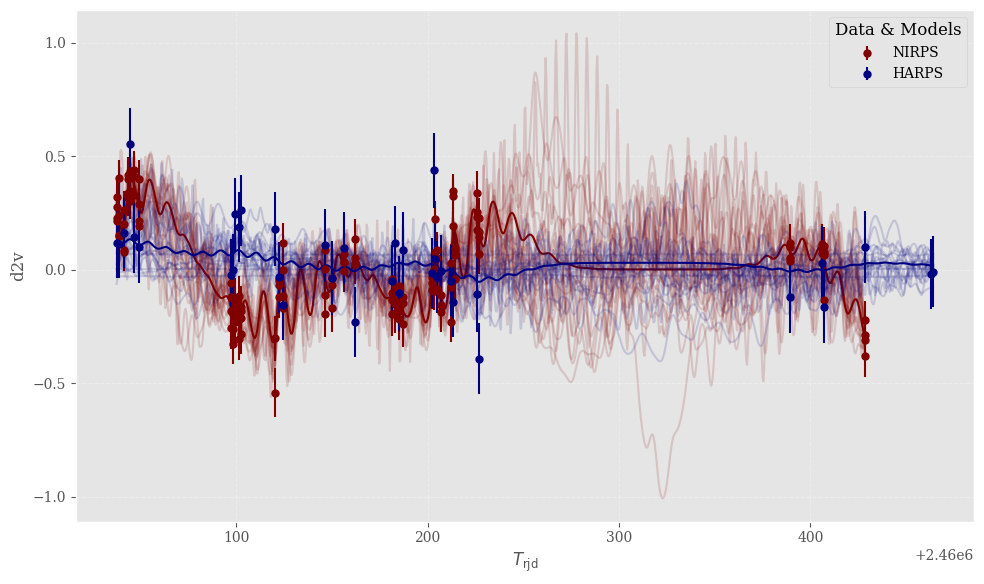

In [19]:
print('Plotting the best-fit results')

# Initialize dictionaries to store predictions and standard deviations
mu_med = {}
std_med = {}

# Predict for each instrument
for instrument, gp_model in act_gp.items():
    # Median likelihood parameters
    gp_model.gp.set_parameter_vector(separated_best_params_dict[instrument])
    mu_med[instrument], var_med = gp_model.gp.predict(act[instrument], data.t_mod[instrument], return_var=True)

# Plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

for idx, (instrument, color) in enumerate(zip(act_gp.keys(), colors)):
    # Plot data with error bars
    axes.errorbar(data.t_rv[instrument], act[instrument], yerr=np.sqrt(sact[instrument]**2 + np.exp(separated_best_params_dict[instrument][1])), 
                  fmt="o", ms=5, label=instrument, color=color)
    
    # Plot samples from posterior
    axes.plot(data.t_mod[instrument], model_post_samples[instrument].T, color=color, alpha=0.15)
    
    # Plot median likelihood
    axes.plot(data.t_mod[instrument], mu_med[instrument], color=color, linewidth=1.5)

# Axes and labels
axes.set_ylabel(f"{data.activity_priors['chosen_activity']}")
axes.set_xlabel(r"$T_{\rm rjd}$")  # Use Latex for unit

# Conditionally setting y-limits based on activity indicator
if data.activity_priors['chosen_activity'] == 'Dtemp': 
    plt.ylim(bottom=-50, top=50)
#if data.activity_priors['chosen_activity'] == 'd2v': 
    #plt.ylim(bottom=-2, top=2)

axes.grid(linestyle='--', alpha=0.3)
plt.legend(title="Data & Models", loc='upper right')  # Adjust legend position
plt.tight_layout()  # Adjust spacing

# Saving figure
star_name = data.data['star']['name']
plt.savefig(working_path + 'activity_GP_best_fit.png', dpi=300)  # Ensure high resolution

print('Done.')


Done! 